In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import matplotlib.pyplot as plt
import numpy as np
from rich import print
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from aifeel.model.nn import NNClassifier
from aifeel.util import gen_dataframe, read_corpus
from aifeel.util.feature_extraction import extract_features, feature_to_vector
from aifeel.util.preprocess import preprocess_text

# 1. Load data

In [57]:
negative_corpus, positive_corpus = read_corpus("negative-reviews"), read_corpus(
    "positive-reviews"
)
negative_words, positive_words = set(read_corpus("negative-words")), set(
    read_corpus("positive-words")
)

In [58]:
df = gen_dataframe(positive_corpus, negative_corpus, random_state=42)
df["clean_review"] = df["review"].apply(preprocess_text)

In [59]:
# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Fit and transform the cleaned reviews
X = vectorizer.fit_transform(df['clean_review'])
y = df['tag']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# 2. Evaluate function

In [60]:
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
def evaluate(model, model_name, X_train, y_train, X_test, y_test):
    cross_score = cross_val_score(model, X_train, y_train, cv=10)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Evaluation:")
    print(f"Cross-Validation Scores: {cross_score}")
    print(f"Cross-Validation Average Score: {cross_score.mean():.2f}")
    print(f"Accuracy Scores: {accuracy}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "positive"])
    disp.plot()
    disp.ax_.set(title='Confusion Matrix')
    plt.show()

   # Plot ROC curve
    y_scores = model.predict_proba(X_test)[:, 1]
    
    # Convert string labels to integers
    y_test_int = y_test.astype(int)
    
    fpr, tpr, _ = roc_curve(y_test_int, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()



# 3. Testing with model

Logistic Regression Evaluation:

Cross-Validation Scores: [0.8509375 0.8478125 0.849375  0.8384375 0.8490625 0.85375   0.8421875
 0.835     0.8509375 0.85     ]

Cross-Validation Average Score: 0.85

Accuracy Scores: 0.851625

Classification Report:

precision    recall  f1-score   support

           0       0.80      0.94      0.86      4000
           1       0.92      0.77      0.84      4000

    accuracy                           0.85      8000
   macro avg       0.86      0.85      0.85      8000
weighted avg       0.86      0.85      0.85      8000

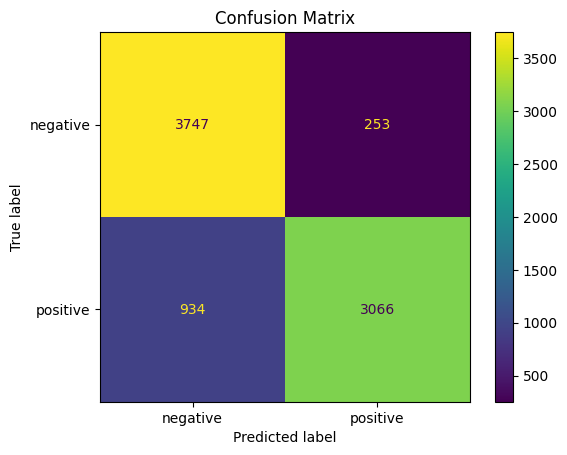

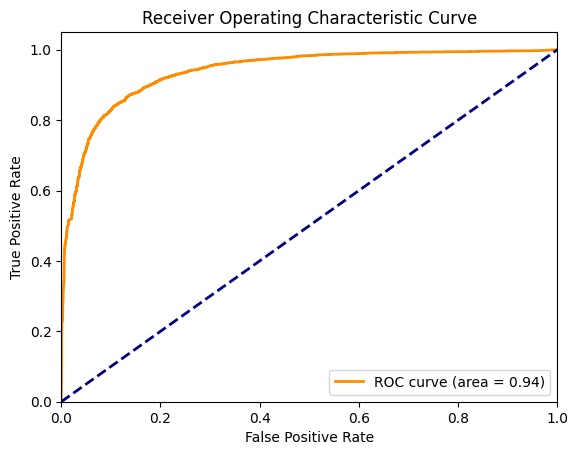

In [61]:
from sklearn.linear_model import LogisticRegression

models = {
    "Logistic Regression": LogisticRegression(C=0.01),
}

for model_name, model in models.items():
    evaluate(model, model_name, X_train, y_train, X_test, y_test)